## 7.4.1 载入数据

In [1]:
# 数据导入到列表
academy_titles, job_titles = [], []

with open(r'academy_titles.txt', encoding='utf8') as f:
    for l in f:
        academy_titles.append(l.strip())

with open(r'job_titles.txt', encoding='utf8') as f:
    for l in f:
        job_titles.append(l.strip())

print(academy_titles[:5])
print(job_titles[:5])

['北师教育学，你我一起努力，让胜利酣畅淋漓。', '考博英语词汇', '出售人大新闻学院2015年考研权威资料', '【脑科院 郭桃梅课题组】科研助理招聘', '管理学院的同学帮帮忙呐～']
['【字节跳动内推】校招岗位全面开放，帮查进度！', '招聘兼职/ 笔试考务 /200-300 每人', '国企出版社招聘坐班兼职生', '【在线早教】教研实习生招聘', '【兼职】心理学公众号寻兼职写手']


In [2]:
char_set = set()

for title in academy_titles + job_titles:
    [char_set.add(ch) for ch in title]
        
print(len(char_set))

char_list = list(char_set)
n_chars = len(char_list) + 1

1570


In [3]:
import torch

def title_to_tensor(title):
    tensor = torch.zeros(len(title), dtype=torch.long)
    for li, ch in enumerate(title):
        try:
            ind = char_list.index(ch)
        except ValueError:
            ind = n_chars - 1
        tensor[li] = ind
    return tensor

## 7.4.2 定义模型

In [4]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, word_count, embedding_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(word_count, embedding_size)
        self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers=2, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=0)
        
    def forward(self, input_tensor):
        word_vector = self.embedding(input_tensor)
        output = self.LSTM(word_vector)[0][0][len(input_tensor)-1]
        output = output.reshape(2, -1).sum(axis=0)
        output = self.cls(output)
        output = self.softmax(output)
        return output

## 7.4.3 训练模型

In [5]:
def run_lstm(rnn, input_tensor):
    output = rnn(input_tensor.unsqueeze(dim=0))
    return output

In [6]:
def train(rnn, criterion, input_tensor, category_tensor):
    rnn.zero_grad()
    output = run_lstm(rnn, input_tensor)
    loss = criterion(output.unsqueeze(dim=0), category_tensor)
    loss.backward()

    # 根据梯度更新模型的参数
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [7]:
def evaluate(lstm, input_tensor):
    with torch.no_grad():
        output = run_lstm(lstm, input_tensor)
        return output

In [8]:
import random

all_data = []
categories = ['考研信息', '招聘信息']
for l in academy_titles:
    all_data.append((title_to_tensor(l), torch.tensor([0], dtype=torch.long)))
for l in job_titles:
    all_data.append((title_to_tensor(l), torch.tensor([1], dtype=torch.long)))
    
random.shuffle(all_data)
data_len = len(all_data)
split_ratio = 0.7

train_data = all_data[:int(data_len * split_ratio)]
test_data = all_data[int(data_len * split_ratio):]
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 4975
Test data size: 2133


In [9]:
from tqdm import tqdm

epoch = 5
embedding_size = 128
n_hidden = 10
n_categories = 2
learning_rate = 0.005
lstm = LSTM(n_chars, embedding_size, n_hidden, n_categories)
criterion = nn.NLLLoss()
loss_sum = 0
all_losses = []
plot_every = 100
for e in range(epoch):
    for ind, (title_tensor, label) in enumerate(tqdm(train_data)):
        output, loss = train(lstm, criterion, title_tensor, label)
        loss_sum += loss
        if ind % plot_every == 0:
            all_losses.append(loss_sum / plot_every)
            loss_sum = 0
    c = 0
    for title, category in tqdm(test_data):
        output = evaluate(lstm, title)
        topn, topi = output.topk(1)
        if topi.item() == category[0].item():
            c += 1
    print('accuracy', c / len(test_data))

100%|██████████| 2133/2133 [00:01<00:00, 1109.86it/s]


accuracy 0.9685888420065635


100%|██████████| 2133/2133 [00:01<00:00, 1095.44it/s]


accuracy 0.9962494139709329


100%|██████████| 2133/2133 [00:01<00:00, 1111.27it/s]


accuracy 0.9981247069854665


100%|██████████| 2133/2133 [00:01<00:00, 1110.78it/s]


accuracy 0.9976558837318331


100%|██████████| 2133/2133 [00:01<00:00, 1118.26it/s]

accuracy 0.9981247069854665


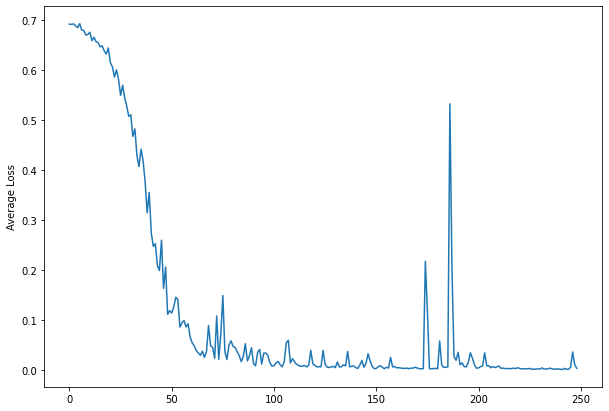

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.ylabel('Average Loss')
plt.plot(all_losses[1:])